In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import cv2
import librosa
from textblob import TextBlob
from flask import Flask, request, jsonify
from flask_cors import CORS
from typing import Union 
from fastapi import FastAPI

In [2]:
# Load the FER2013 dataset
data_path = 'C:/Users/anjal/OneDrive/Documents/fer2013.csv'  # Replace with the path to your dataset
data = pd.read_csv(data_path)

# Extract features (pixels) and labels (emotion categories)
pixels = data['pixels'].tolist()
labels = data['emotion'].tolist()

# Convert pixel data into a 3D NumPy array (48x48x1 grayscale images)
X = np.array([np.fromstring(pixel, sep=' ').reshape(48, 48, 1) for pixel in pixels], dtype='float32')

# Normalize the pixel values (scale between 0 and 1)
X = X / 255.0

# Convert labels to one-hot encoding
y = to_categorical(labels, num_classes=7)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotion classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.2463 - loss: 1.8203 - val_accuracy: 0.3551 - val_loss: 1.6456
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.3622 - loss: 1.6232 - val_accuracy: 0.4448 - val_loss: 1.4548
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.4320 - loss: 1.4691 - val_accuracy: 0.4714 - val_loss: 1.3761
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.4684 - loss: 1.3881 - val_accuracy: 0.5086 - val_loss: 1.2838
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.4848 - loss: 1.3430 - val_accuracy: 0.5286 - val_loss: 1.2615
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.5039 - loss: 1.3044 - val_accuracy: 0.5401 - val_loss: 1.2229
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.5213 - loss: 1.2691 - val_accuracy: 0.5479 - val_loss: 1.1992
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.5280 - loss: 1.2403 - 

Test Accuracy: 60.57%


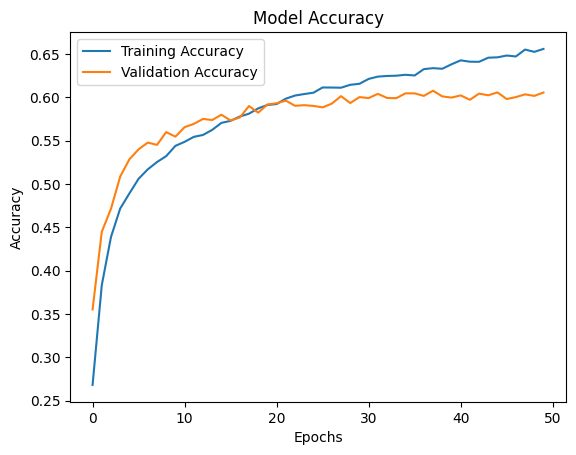

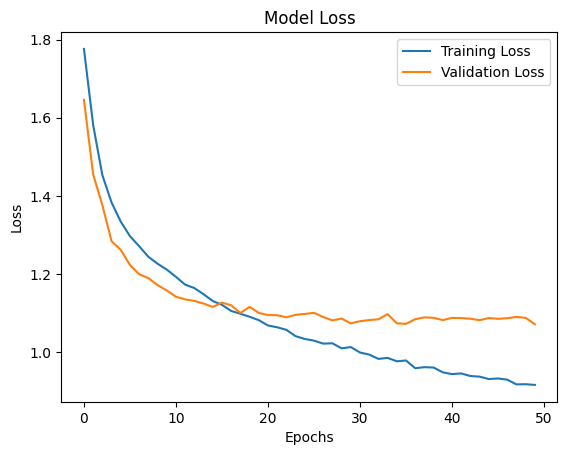

In [7]:
# Save the trained model
model.save('emotion_detection_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


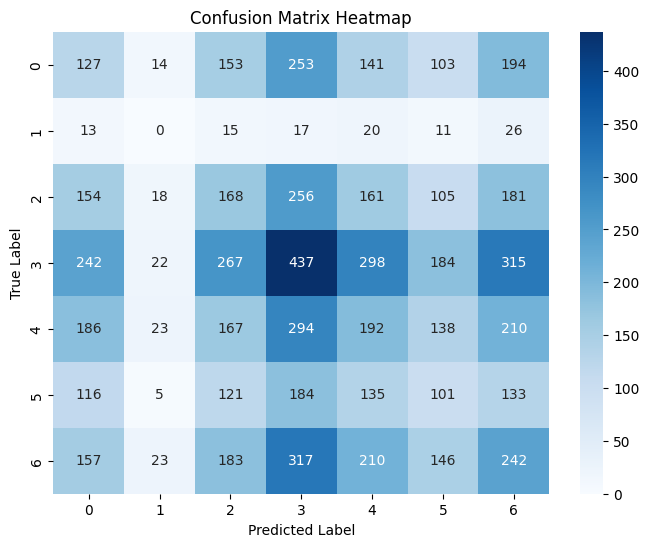

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the FER2013 dataset (update the path as needed)
data_path = 'C:/Users/anjal/OneDrive/Documents/fer2013.csv'  # Replace with the correct path
data = pd.read_csv(data_path)

# Inspect the first few rows to identify the features and labels
print(data.head())

# Generate a correlation heatmap (optional, if the data has numerical features)
if 'pixels' not in data.columns:
    # For numerical data only (excluding categorical data like 'emotion')
    correlation_matrix = data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap')
    plt.show()

# Process for a Confusion Matrix Heatmap
# Assume 'emotion' as the target label and 'pixels' as the features
pixels = data['pixels'].tolist()
labels = data['emotion'].tolist()

# Convert pixel data into arrays
X = np.array([np.fromstring(pixel, sep=' ').reshape(48, 48, 1) for pixel in pixels], dtype='float32')
X = X / 255.0  # Normalize the pixel values

# One-hot encoding for labels (if not already done)
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels, num_classes=7)

# Simulate a confusion matrix (use your model's predictions)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Replace this with your model's predictions
y_pred = np.random.choice(y_test, size=len(y_test))  # Simulate predictions
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [9]:
# Load the trained model
model = load_model('emotion_detection_model.h5')
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


In [10]:
# Audio Emotion Detection Placeholder
def analyze_audio_emotion(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        # Placeholder for actual audio model
        audio_emotion = "Neutral"  # Replace with prediction logic
        return audio_emotion
    except Exception as e:
        print(f"Audio analysis error: {e}")
        return "Error"

In [11]:
# Text Sentiment Analysis
def analyze_text_emotion(text):
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment > 0:
        return "Positive"
    elif sentiment < 0:
        return "Negative"
    else:
        return "Neutral"

In [12]:
# Calculate overall sentiment
def calculate_overall_sentiment(facial_emotion, audio_emotion, text_emotion):
    sentiment_scores = {
        'Positive': 1,
        'Neutral': 0,
        'Negative': -1
    }
    
    facial_score = sentiment_scores.get(facial_emotion, 0)
    audio_score = sentiment_scores.get(audio_emotion, 0)
    text_score = sentiment_scores.get(text_emotion, 0)
    
    overall_score = facial_score + audio_score + text_score
    
    if overall_score > 0:
        return "Positive"
    elif overall_score < 0:
        return "Negative"
    else:
        return "Neutral"


In [13]:
# Start webcam
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi_gray = roi_gray / 255.0
        roi_gray = roi_gray.reshape(1, 48, 48, 1)

        prediction = model.predict(roi_gray)
        emotion = emotion_labels[np.argmax(prediction)]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    cv2.imshow('Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Analyzing audio...")
        audio_emotion = analyze_audio_emotion("C:/Users/anjal/Downloads/hello-46355.mp3")  # Replace with actual audio file path
        print(f"Audio Emotion: {audio_emotion}")

        print("Analyzing speech...")
        speech_emotion = analyze_speech_emotion()
        print(f"Speech Emotion: {speech_emotion}")

        overall_emotion = calculate_overall_sentiment(facial_emotion, audio_emotion, text_emotion)
        print(f"Overall Sentiment: {overall_emotion}")
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━

KeyboardInterrupt: 

: 

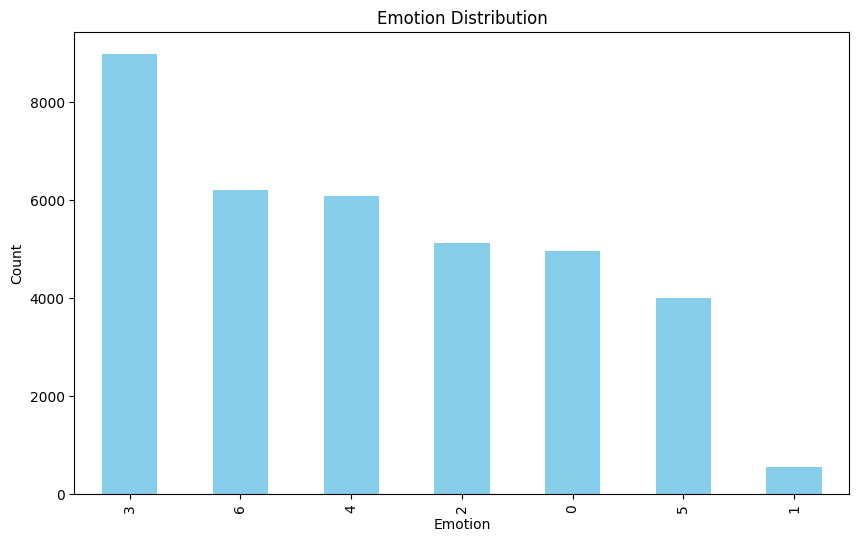

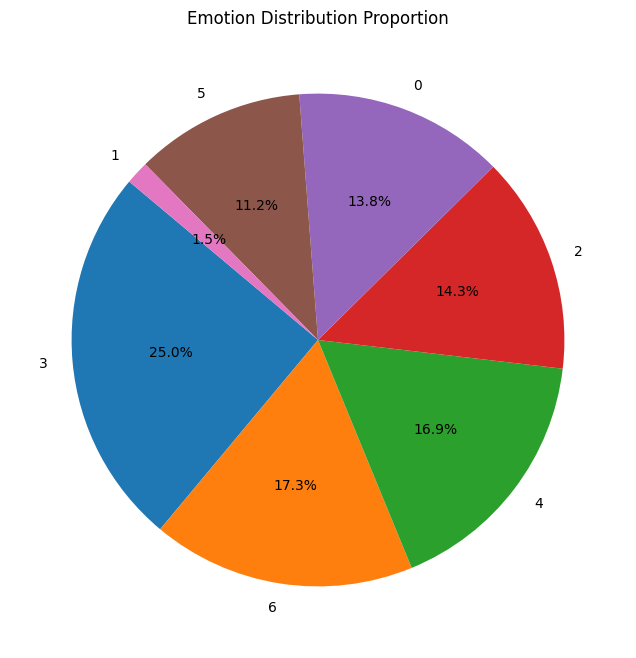

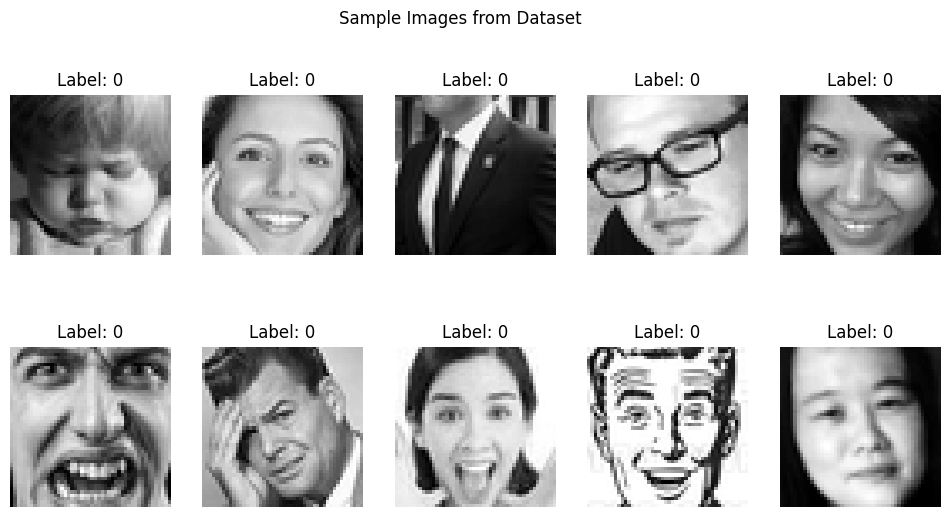

In [13]:
pixels = data['pixels'].tolist()
labels = data['emotion'].tolist()

# Convert pixel data into arrays
X = np.array([np.fromstring(pixel, sep=' ').reshape(48, 48, 1) for pixel in pixels], dtype='float32')
X = X / 255.0  # Normalize the pixel values

# One-hot encoding for labels (if not already done)
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels, num_classes=7)

# Simulate a confusion matrix (use your model's predictions)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

emotion_counts = data['emotion'].value_counts()
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# Pie chart for proportions
plt.figure(figsize=(8, 8))
emotion_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title('Emotion Distribution Proportion')
plt.ylabel('')  # Hide the y-label for better visualization
plt.show()

    
plt.figure(figsize=(12, 6))
for i in range(1, 11):  # Show 10 images
    plt.subplot(2, 5, i)
    plt.imshow(X_train[i].reshape(48, 48), cmap='gray')
    plt.title(f'Label: {np.argmax(y_train[i])}')
    plt.axis('off')
plt.suptitle('Sample Images from Dataset')
plt.show()

   







